In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import unittest

def whichbin(x, left_edges, dx):
    '''Function to return the bin number (starting from 0)
    that the water balloon is. arguments include `x`, the
    measured position of the balloon, and `left_edges`, an
    array of the x-coordinates of the left edges of the bins.
    Returns False if balloon is outside the domain.
    '''
    this_one = [k for k in range(len(left_edges)) if x >= left_edges[k] and x <= left_edges[k]+dx]
    return this_one[0] if this_one else False

---


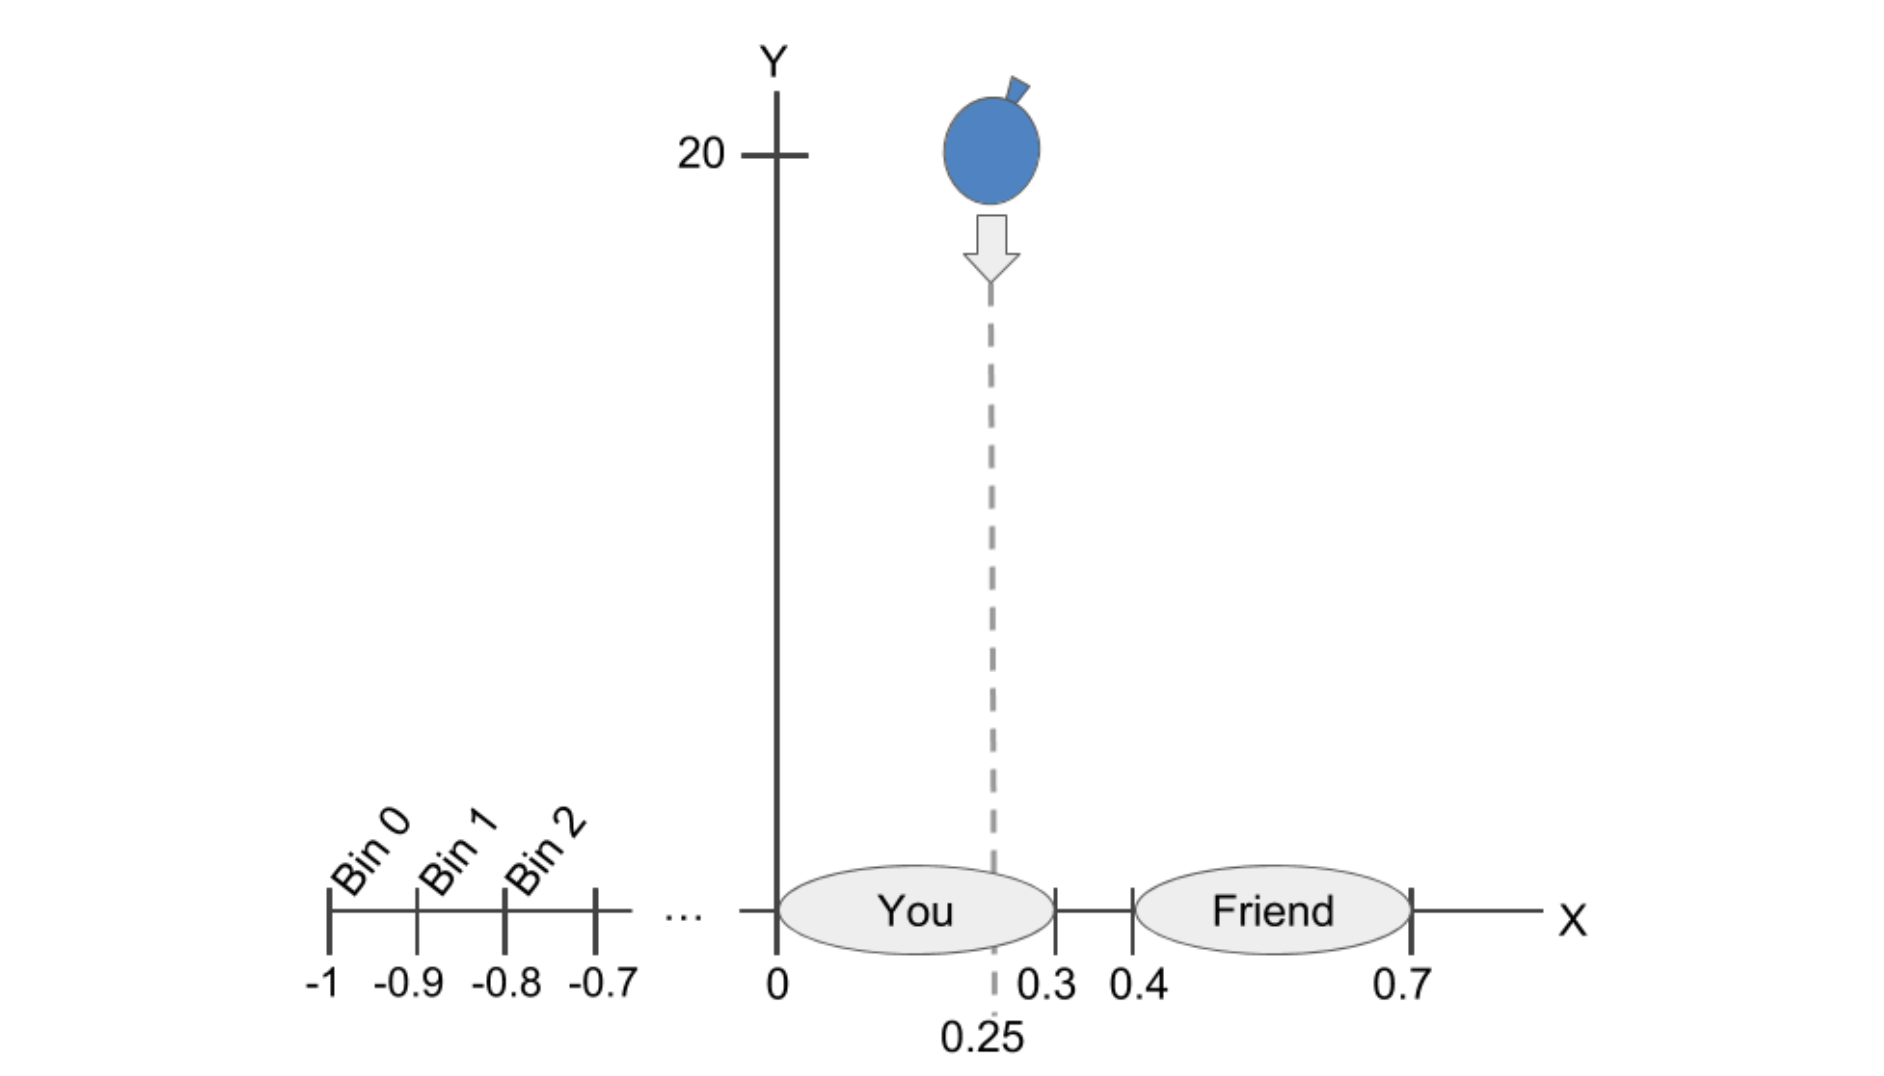

## Problem 1:  Water balloon tracking

Suppose you are walking down the street with your friend, when your sensors pick up a dangerous ***water balloon*** incoming! To track the water balloon and update your assessment of the probabilities that you or your friend will be hit, you think fast and implement a Hidden Markov Model. Unfortunately, you and your friend are also so busy implementing this model that you don't simply move out of the way (i.e., assume you are both stationary throughout this problem).

First, you discretize the environment by using bins in the x-direction of width $\Delta x = 0.1$ meters and time steps of 1/20 of a second. You do not need to consider any motion in the z-direction. The balloon starts 20 meters away in the y-direction at $(x_0, y_0)=(0.25,20)$, and is moving toward you at constant speed of $v = 2$ meters/second in the -y direction.

Since we are dealing with a discretized world, it might be easier to work with the actual **bin numbers** as opposed to decimal values for x.  And we can use the helper function `whichbin` to determine which bin numbers correspond to which raw x coordinate values. So let's keep track of $(\text{bin number}, y)$ tuple pairs as coordinates, where it should be clear from context whether we are referring to actual $x$ position or bin position.

Now, in addition to this constant movement towards you, the water balloon also experiences some random fluctuations in its $x$ coordinate along its path. If the balloon is in bin $i$ in time step $t$, then in time step $t+1$ the balloon is:
* still on course (in bin $i$) with probability $0.7$,
* in either of the adjacent bins ($i\pm 1$) with probability $0.1$, and
* in either of the bins 2 away ($i\pm 2$) with probability $0.05$.

Your torso occupies the region $0 \le x \le 0.3$, and your friend occupies the region $0.4 \le x \le 0.7$. So there are exactly 3 bins that correspond to hitting you, and 3 that correspond to hitting your friend. Assume that when the balloon reaches $y=0$, if it is within either of these $x$ regions, then it will hit you or your friend. 

Your sensors (i.e., perception) are fairly accurate, but there is some uncertainty in the x direction. When you measure the balloon's x-position, if the water balloon is actually in bin $i$, then:
* you get it exactly correct 5/17 of the time,
* you measure bins $i\pm 1$ each with probability 3/17,
* you measure bins $i\pm 2$ each with probability 2/17, and
* you measure bins $i\pm 3$ each with probability 1/17.

<br>


### (1a) 

First let's set up the discretized environment.

In [19]:
v = 2                        # speed of the water balloon
dt = 1/20                    # time step (seconds)
dx = 0.1                     # bin width along x
xb = np.arange(-1, 1.5, dx)  # x-coordinates of left-edges of bins
n_bins = len(xb)             # total number of bins
initial_location = (whichbin(0.25, xb, dx), 20)  # initial (bin, y) location of balloon


my_bins = [10, 11, 12]
friend_bins = [14, 15, 16]




print("xb:", xb)
print("num of bins:", n_bins)
print("init loc:", initial_location)

xb: [-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01
  1.00000000e+00  1.10000000e+00  1.20000000e+00  1.30000000e+00
  1.40000000e+00]
num of bins: 25
init loc: (12, 20)


Which bin numbers would the balloon need to be in in order to hit you at $y=0$?  What about your friend?  Store this information in some kind of variable - you may need to use it later.

Given the time step, speed in the y-direction, and initial distance of the water balloon, how many time steps, $T$, are there until the balloon reaches $y=0$?

In [20]:
hit_me_bins = [whichbin(x, xb, dx) for x in np.arange(0, 0.3, dx)]
print("Bins to hit you:", hit_me_bins)

hit_friend_bins = [whichbin(x, xb, dx) for x in np.arange(0.4, 0.7, dx)]
print("Bins to hit your friend:", hit_friend_bins)

T = int(np.ceil(20 / abs(v) / dt))
print("Number of time steps until the balloon reaches y=0:", T)


Bins to hit you: [10, 11, 12]
Bins to hit your friend: [14, 15, 16]
Number of time steps until the balloon reaches y=0: 200


### (1b)

Set up a `Balloon` class.  Include attributes for:
* balloon speed
* the probabilities associated with changes in the balloon's x-position (by bin) from one time step to the next (i.e., the Markov transition probabilities)
* the current balloon location
* the time step for the simulation

and methods for:
* updating the x- and y-positions of the balloon between time steps. The x-position that you track should be the bin.
* declaring (through Boolean output) whether or not the balloon has arrived at $y=0$. This one might require you to carefully account for any floating point operations that lead to a non-integer y-position being compared against the integer 0.

In [21]:
class Balloon:
    def __init__(self, speed, probs, location, dt):
        self.speed = speed 
        self.transition_probs = probs  
        self.location = location  #tuple (bin, y)
        self.dt = dt  
    
    def update_position(self):
        self.location = (self.location[0], self.location[1] - self.speed * self.dt)
        current_bin = self.location[0]
        choices = [current_bin + i for i in range(-2, 3)]  
        probabilities = [self.transition_probs.get(i, 0) for i in range(-2, 3)]
        new_bin = np.random.choice(choices, p=probabilities)
        self.location = (new_bin, self.location[1])
        
        return self.location

### (1c)

Set up a `Sensor` class to represent your ability to measure the balloon's position. Include an attribute for the sensor model probabilities, as well as a method `measure`, to return the measured $(x,y)$ pair as a tuple. The x-coordinate, however, should be the bin that you perceived the balloon to be in.

In [22]:
class Sensor:
    def __init__(self, measurement_probs):
        self.measurement_probs = measurement_probs

    def measure(self, true_bin):
        outcomes = [true_bin + i for i in range(-3, 4)]  
        probabilities = [self.measurement_probs[i] for i in range(-3, 4)]  
        measured_bin = np.random.choice(outcomes, p=probabilities)
        return measured_bin
    
transition_probs = {0: 0.7, 1: 0.1, -1: 0.1, 2: 0.05, -2: 0.05}
measurement_probs = {0: 5/17, 1: 3/17, -1: 3/17, 2: 2/17, -2: 2/17, 3: 1/17, -3: 1/17}

balloon = Balloon(speed=2, probs=transition_probs, location=(10, 20), dt=1/20)
sensor = Sensor(measurement_probs=measurement_probs)


### (1d)

Generate a simulated Markov chain sequence of water balloon states (bins along x-direction, $X$) and your corresponding measurements of those states ($E$). Make a plot of these two time series on the same axes, and be sure to include axis labels and a legend. 

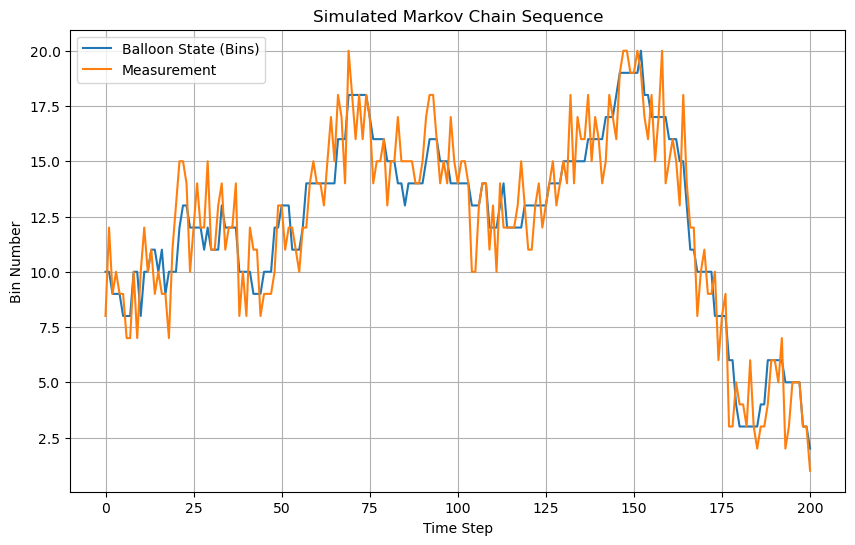

In [23]:
T = 200  #number of time steps
X_sequence = []  #balloon state sequence (bins along x-direction)
E_sequence = []  #corresponding measurements sequence

X_sequence.append(balloon.location[0])
E_sequence.append(sensor.measure(balloon.location[0]))

for _ in range(T):
    balloon.update_position()
    X_sequence.append(balloon.location[0])
    E_sequence.append(sensor.measure(balloon.location[0]))

plt.figure(figsize=(10, 6))
plt.plot(X_sequence, label='Balloon State (Bins)')
plt.plot(E_sequence, label='Measurement')
plt.xlabel('Time Step')
plt.ylabel('Bin Number')
plt.title('Simulated Markov Chain Sequence')
plt.legend()
plt.grid(True)
plt.show()


### (1e)

Recall that `Forward` filtering updates our estimate of the probability distribution for $X_t$ in light of *all* of the evidence up to time $t$, $E_{1:t}$, as

$$f_{1:t} = \alpha ~ \texttt{forward}(f_{1:t-1}, E_t)$$
 
and the `Backward` function is a necessary step to update our estimate of the probability distribution for $X_k$ (some $k$ in $[0,t]$) in light of *all* of the evidence that occurred after $k$, $E_{k+1:t}$, as:

$$b_{k+1:t} = \texttt{backward}(b_{k+2:t}, E_{k+1})$$

where the specific functional forms of these recurrences is given in the textbook and lecture slides.

Code up `forward` and `backward` functions, taking in as arguments:
* `f1` or `b1`, the relevant previous (forward) or future (backward) "probability distribution" from the last recursive function call, respectively,
* `evidence`, which is the single observation that you are assimilating,
* `sens`, a `Sensor` object,
* `ball`, a `Balloon` object, and
* `xb`, some way to denote where the bins or x-coordinates are (which is more convenient may depend on how you stored your sensor and Markov transition probabilities).

Note that `forward` should return *all* of the probability distributions, at each time step, because you will need these for `backward`, which should return a single probability distribution.

In [24]:
def forward(f_prev, evidence, sensor, balloon, xb):
    n_bins = len(xb)
    f_update = np.zeros(n_bins)
    
    for i in range(n_bins):
        sensor_prob = sensor.measurement_probs.get(evidence - i, 0)
        if sensor_prob > 0:
            for j in range(n_bins):
                trans_prob = balloon.transition_probs.get(i - j, 0)
                f_update[i] += f_prev[j] * trans_prob * sensor_prob

    total_prob = np.sum(f_update)
    if total_prob > 0:
        f_update /= total_prob

    return f_update

def backward(b_next, evidence, sensor, balloon, xb):
    n_bins = len(xb)
    b_update = np.zeros(n_bins)
    
    for i in range(n_bins):
        for j in range(n_bins):
            sensor_prob = sensor.measurement_probs.get(evidence - j, 0)
            trans_prob = balloon.transition_probs.get(j - i, 0)
            b_update[i] += b_next[j] * trans_prob * sensor_prob

    total_prob = np.sum(b_update)
    if total_prob > 0:
        b_update /= total_prob

    return b_update

### (1f)

**For the remainder of this problem**, use the data set [data_waterballoon.csv]. The first column ($X$) corresponds to the actual bin number in which the water balloon is located during the time step corresponding to that row in the data table, and the second column ($E$) is the associated measurement. Note that there is no measurement associated with the initial location. You should use a uniform prior distribution for the initial location, over the actual location and one bin to either side.

Use your `forward` and `backward` functions to implement the forward-backward algorithm to obtain both filtered estimates and smoothed estimates of the probability distribution for water balloon location for all times after the initial time step.

In [25]:
data_waterballoon_path = 'data_waterballoon.csv'
data_waterballoon = pd.read_csv(data_waterballoon_path)

prior_probs = np.ones(len(xb)) / len(xb)  

forward_probs = [prior_probs.copy()]
backward_probs = [np.ones(len(xb)) / len(xb) for _ in range(len(data_waterballoon))]  

valid_measurements = data_waterballoon['E'][1:] 

for measurement in valid_measurements:
    if not np.isnan(measurement):
        forward_probs.append(forward(forward_probs[-1], int(measurement), sensor, balloon, xb))

for i in reversed(range(len(valid_measurements))):
    if not np.isnan(valid_measurements.iloc[i]):
        backward_probs[i] = backward(backward_probs[i + 1], int(valid_measurements.iloc[i]), sensor, balloon, xb)

smoothed_probs = []
for i in range(len(forward_probs)):
    total_prob = np.sum(forward_probs[i] * backward_probs[i])
    smoothed_probs.append((forward_probs[i] * backward_probs[i]) / total_prob if total_prob > 0 else forward_probs[i])

print("Filtered Estimates (Forward Probabilities):")
for i, f_prob in enumerate(forward_probs[1:], start=1):  # Start from 1 to skip initial distribution
    print(f"Time Step {i}: {f_prob}")

print("\nSmoothed Estimates (Smoothed Probabilities):")
for i, s_prob in enumerate(smoothed_probs[1:], start=1):  # Start from 1 to match the forward_probs index
    print(f"Time Step {i}: {s_prob}")


Filtered Estimates (Forward Probabilities):
Time Step 1: [0.         0.         0.         0.         0.         0.
 0.05882353 0.11764706 0.17647059 0.29411765 0.17647059 0.11764706
 0.05882353 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Time Step 2: [0.         0.         0.         0.         0.         0.0045045
 0.0472973  0.13851351 0.33783784 0.29054054 0.13513514 0.04617117
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Time Step 3: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.32688903 0.36512995 0.22774591
 0.07152468 0.00871043 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Time Step 4: [0.         0.         0.         0.         0.         0.
 0.         0.02472614 0.12845167 0.41863031 0.31731883 0.11087304


How does the filtered estimate at $t=1$ (first time step, not 1 second) differ from what you would estimate based only on the Markov model, without knowledge of $E_1$, your first measurement of balloon position?  To solve for the Markov model probability distribution $P(X_1)$, you can either use enumeration or calculate the probabilities by hand. (By hand isn't too bad, because there is nice symmetry you can take advantage of, so you only need to actually calculate a few things.)

Plot the two probability distributions on the same set of axes and comment on the differences. Be sure to include appropriate axis labels and a legend.

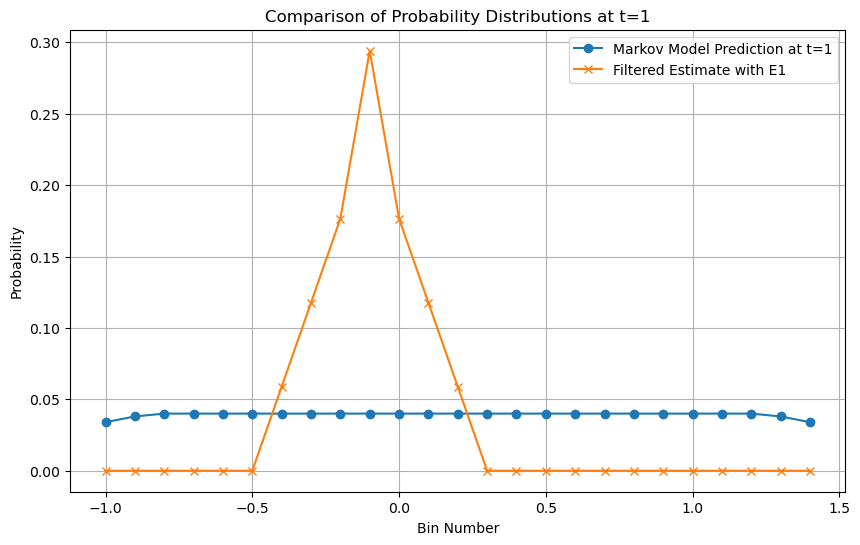

In [26]:
def markov_update(prior, transition_probs, xb):
    n_bins = len(xb)
    next_probs = np.zeros(n_bins)
    
    for i in range(n_bins):
        for offset, prob in transition_probs.items():
            if 0 <= i + offset < n_bins:
                next_probs[i + offset] += prior[i] * prob
    return next_probs

markov_probs_t1 = markov_update(prior_probs, transition_probs, xb)

filtered_estimate_t1 = forward_probs[1]

plt.figure(figsize=(10, 6))
plt.plot(xb, markov_probs_t1, label='Markov Model Prediction at t=1', marker='o')
plt.plot(xb, filtered_estimate_t1, label='Filtered Estimate with E1', marker='x')
plt.title('Comparison of Probability Distributions at t=1')
plt.xlabel('Bin Number')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

### (1g)

Based on the smoothed estimates for the probability distribution of the water balloon at the moment the balloon reaches $y=0$, calculate the following:
* the probability that the balloon hits you,
* the probability that the balloon hits your friend, and you
* the probability that the balloon misses both of you.



Here is the expected output for 1g: 0.6695732845120801,  0.0,  0.3304267154879199 (in the same order as the bullets)

In [27]:

my_bins = range(10, 13)  #bins 10 to 12 (0.0 to 0.3)
friend_bins = range(14, 17)  #bins 14 to 16 (0.4 to 0.7)

final_smoothed_probs = smoothed_probs[-1]

probability_me = sum(final_smoothed_probs[i] for i in my_bins)
probability_friend_and_me= sum(final_smoothed_probs[i] for i in friend_bins)
probability_missing = 1 - (probability_me + probability_friend_and_me)

print("Probability of me:", probability_me)
print("Probability of friend and me:", probability_friend_and_me)
print("Probability of missing both:", probability_missing)

Probability of me: 0.66957328451208
Probability of friend and me: 0.0
Probability of missing both: 0.33042671548792


### (1h)

Make a plot of the smoothed estimates of the probability that the balloon will hit you, as a function of time step, and of the probability that the balloon will hit your friend. Include axis labels and a legend.  Write a few sentences commenting on the plot.

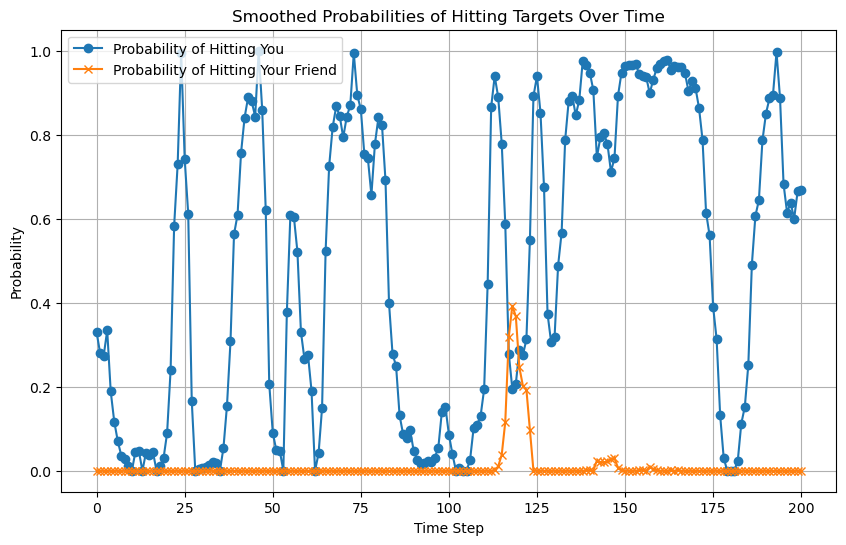

In [28]:
probabilities_you = [sum(probs[i] for i in my_bins) for probs in smoothed_probs]
probabilities_friend = [sum(probs[i] for i in friend_bins) for probs in smoothed_probs]

time_steps = range(len(smoothed_probs))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, probabilities_you, label='Probability of Hitting You', marker='o', linestyle='-')
plt.plot(time_steps, probabilities_friend, label='Probability of Hitting Your Friend', marker='x', linestyle='-')
plt.title('Smoothed Probabilities of Hitting Targets Over Time')
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

### (1i)

Give an example of an improvement we could make to the sensor model so that it would better represent the perception of a typical human being. Your answer should include both a revision of the code snippet below, as well as a few sentences justifying your code modifications. Note that you do **not** need to run this code; ***Pythonic*** pseudocode is fine.

```
class Sensor:    
    def measure(self, balloon):
    
        # your code goes here

    
        return (x_meas, y_meas)
```

**To improve the sensor model you could represent the perception of a typical human being as a Gaussian distribution to model the measurement noise, reflecting how humans perceive objects with more common errors around the true position and rarer larger deviations.**

<br>

---


## Problem 2: your very own MDP

For this problem, you do not need to write any code, but rather communicate your ideas clearly using complete sentences and descriptions of the concepts the questions ask about. You can, of course, include some pseudocode if it helps, but that is not strictly necessary.


### (2a)

Describe something you think would be interesting to model using a Markov decision process.  Be **creative** - do not use any examples from your homework, class, or the textbook, and if you are working with other students, please **come up with your own example**. There are so, SO many possible answers!

I think a MDP involving self driving cars and reducing traffic would be cool to do.


### (2b)

What are the states associated with your MDP?

For this MDP the state space could represent be for example the current location of each car, passenger demand at different locations, traffic conditions, and the vehicle's battery level.

### (2c)

What is the reward structure associated with your MDP?  Include a discussion of terminal/non-terminal states.

The reward structure would be designed to with goals reducing congestion, minimizing carbon emissions, and ensuring efficient travel. 

Terminal states: 
when the time period under consideration ends or when the battery level of all vehicles reaches a critical threshold where they cannot operate anymore. In terminal states, the rewards might reflect the overall performance of the transportation system during the simulation period, incorporating factors like total passenger satisfaction, average travel time, and overall energy consumption.

Non-terminal states: 
the current state of each EAV, passenger demand at different locations, and traffic conditions. Rewards in non-terminal states could be based on the immediate outcomes of actions taken by the city planner, such as successfully picking up passengers, reducing waiting times, or optimizing vehicle routes.
    

### (2d)

What are the actions and transition model associated with your MDP?

The actions include assigning EAVs to pick up passengers, repositioning idle vehicles to high-demand areas, adjusting fares dynamically based on demand and traffic conditions, and implementing policies such as ride-sharing incentives or congestion pricing.

Transition Model:
The transition model would include probabilities for successful passenger pickups, travel times between locations, changes in traffic congestion, and the effect of policy interventions on passenger behavior.

### (2e)

Interpret what an optimal policy represents in the context of your particular MDP.

The optimal policy would be to achieve a balance between passenger convenience, system efficiency, and environmental sustainability, leading to a well-functioning urban transportation system that benefits both residents and the city as a whole.